In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os
import glob
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Mount Google Drive (uncomment when running in Colab)
from google.colab import drive
drive.mount('/content/drive')

In [4]:
#--------------------------------------------------------------------------
# Section 1: Data Loading and Exploration
#--------------------------------------------------------------------------

# Define paths to training and testing data
base_path = '/content/drive/MyDrive/Ohio2020_processed/'
train_files = glob.glob(os.path.join(base_path, 'train/*training_processed.csv'))
test_files = glob.glob(os.path.join(base_path, 'test/*testing_processed.csv'))

In [5]:


# Function to extract patient ID from filename
def extract_patient_id(filename):
    return os.path.basename(filename).split('ws')[0]

# Let's load all training data into a dictionary
train_data = {}
for file in train_files:
    patient_id = extract_patient_id(file)
    train_data[patient_id] = pd.read_csv(file)
    # Add patient_id column to the dataframe
    train_data[patient_id]['patient_id'] = patient_id
    print(f"Loaded training data for patient {patient_id}: {train_data[patient_id].shape} rows")

# Load all testing data into a dictionary
test_data = {}
for file in test_files:
    patient_id = extract_patient_id(file)
    test_data[patient_id] = pd.read_csv(file)
    # Add patient_id column to the dataframe
    test_data[patient_id]['patient_id'] = patient_id
    print(f"Loaded testing data for patient {patient_id}: {test_data[patient_id].shape} rows")

# Combine all patients' data for exploratory analysis
all_train_data = pd.concat(train_data.values(), ignore_index=True)
all_test_data = pd.concat(test_data.values(), ignore_index=True)

# Display basic information about the dataset
print("\nTraining data shape:", all_train_data.shape)
print("Testing data shape:", all_test_data.shape)
print("\nColumn Information:")
all_train_data.info()

Loaded training data for patient 540-: (13109, 10) rows
Loaded training data for patient 552-: (11097, 10) rows
Loaded training data for patient 544-: (12671, 10) rows
Loaded training data for patient 567-: (13535, 10) rows
Loaded training data for patient 596-: (13629, 10) rows
Loaded training data for patient 584-: (13247, 10) rows
Loaded testing data for patient 540-: (3065, 10) rows
Loaded testing data for patient 552-: (3950, 10) rows
Loaded testing data for patient 544-: (3136, 10) rows
Loaded testing data for patient 584-: (2995, 10) rows
Loaded testing data for patient 596-: (3002, 10) rows
Loaded testing data for patient 567-: (2870, 10) rows

Training data shape: (77288, 10)
Testing data shape: (19018, 10)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77288 entries, 0 to 77287
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   5minute_intervals_times


Missing values in training data:
5minute_intervals_timestamp        0
missing_cbg                        0
cbg                            11755
finger                         75663
basal                           1105
hr                             77288
gsr                            29888
carbInput                      76602
bolus                          75761
patient_id                         0
dtype: int64

CGM Statistics:
count    65533.000000
mean       157.700609
std         60.882188
min         40.000000
25%        112.000000
50%        149.000000
75%        193.000000
max        400.000000
Name: cbg, dtype: float64


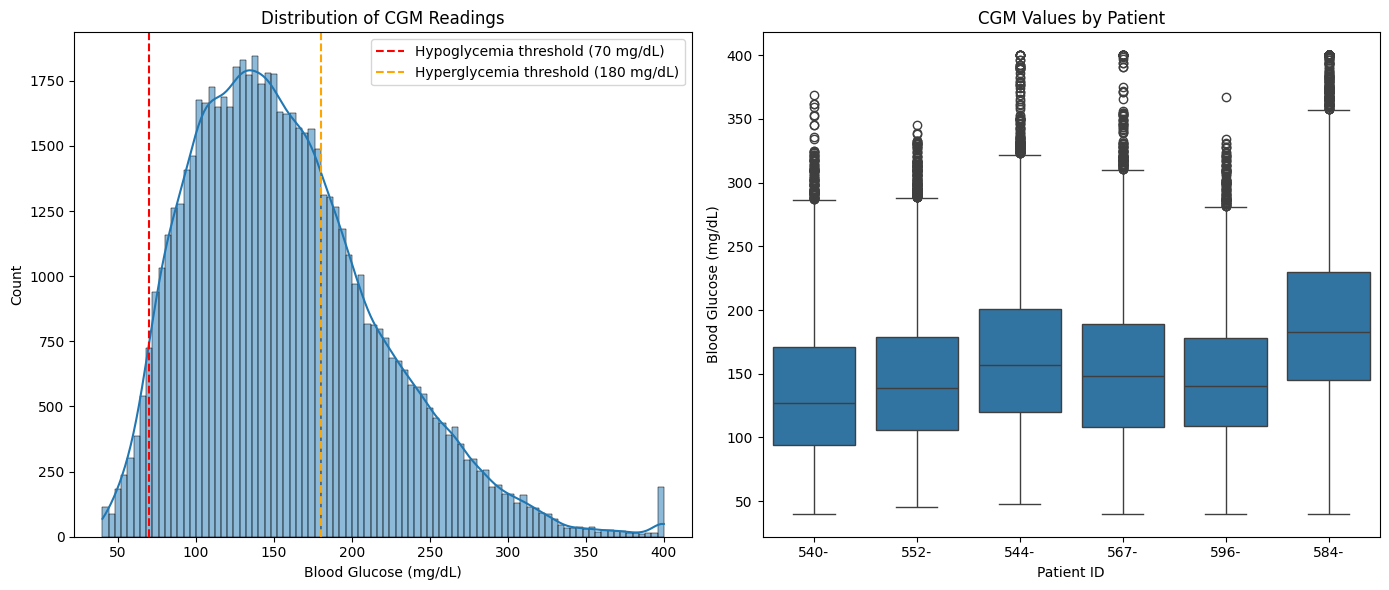

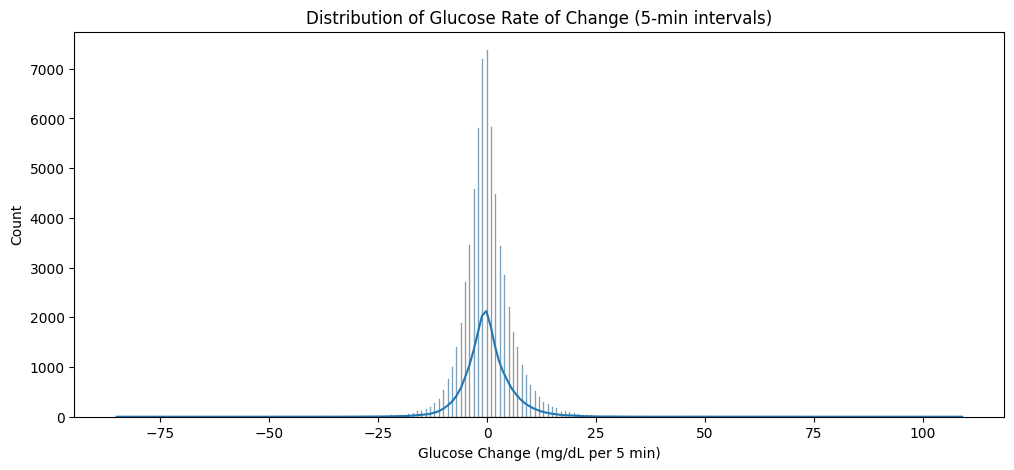

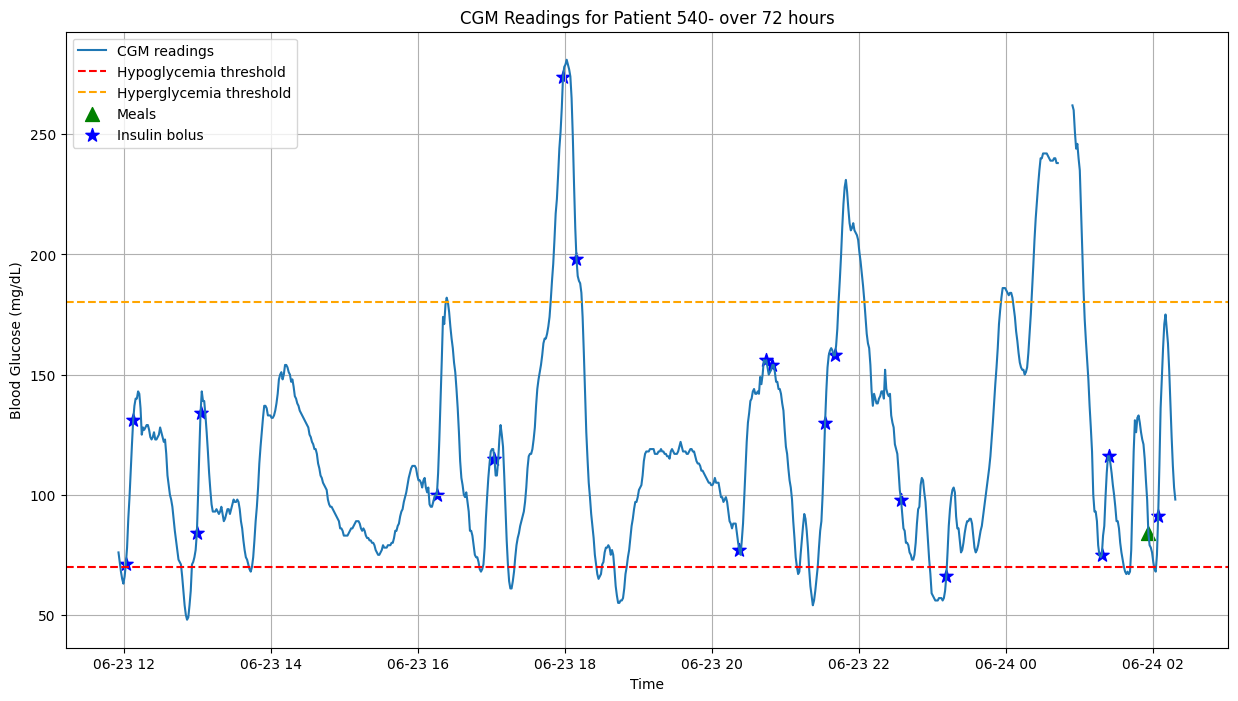

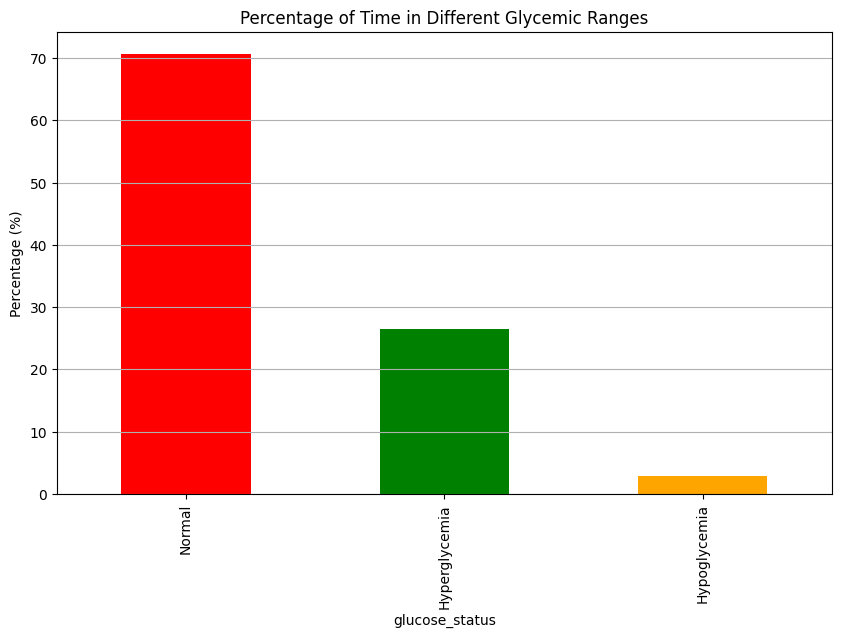

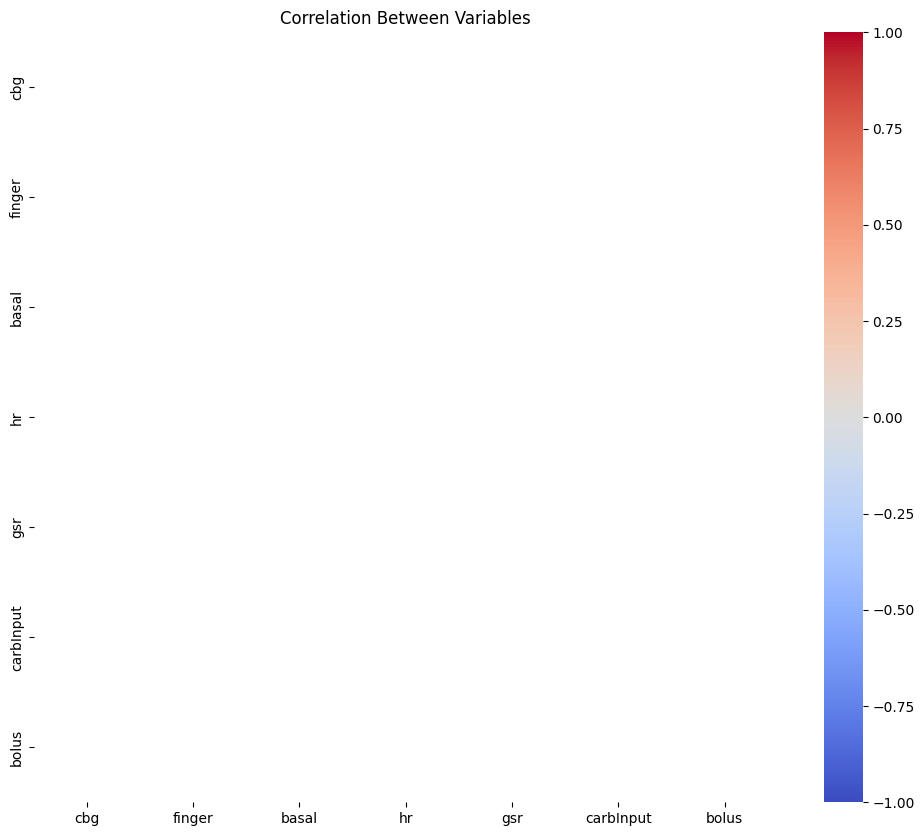

In [6]:
#--------------------------------------------------------------------------
# Section 2: Exploratory Data Analysis (EDA)
#--------------------------------------------------------------------------

# Check for missing values
print("\nMissing values in training data:")
print(all_train_data.isnull().sum())

# Basic statistics of CGM values
print("\nCGM Statistics:")
print(all_train_data['cbg'].describe())

# Visualize distribution of glucose readings
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(all_train_data['cbg'].dropna(), kde=True)
plt.axvline(x=70, color='r', linestyle='--', label='Hypoglycemia threshold (70 mg/dL)')
plt.axvline(x=180, color='orange', linestyle='--', label='Hyperglycemia threshold (180 mg/dL)')
plt.title('Distribution of CGM Readings')
plt.xlabel('Blood Glucose (mg/dL)')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x='patient_id', y='cbg', data=all_train_data)
plt.title('CGM Values by Patient')
plt.xlabel('Patient ID')
plt.ylabel('Blood Glucose (mg/dL)')

plt.tight_layout()
plt.savefig('glucose_distribution.png')
plt.show()

# Calculate and visualize glucose rate of change
all_train_data['glucose_change'] = all_train_data.groupby('patient_id')['cbg'].diff()

plt.figure(figsize=(12, 5))
sns.histplot(all_train_data['glucose_change'].dropna(), kde=True)
plt.title('Distribution of Glucose Rate of Change (5-min intervals)')
plt.xlabel('Glucose Change (mg/dL per 5 min)')
plt.savefig('glucose_change_distribution.png')
plt.show()

# Time series visualization for one patient
patient_id = list(train_data.keys())[0]  # First patient
patient_df = train_data[patient_id].copy()

# Convert timestamp to datetime if it's not already
if 'timestamp' not in patient_df.columns:
    # Create timestamp from 5minute_intervals_timestamp (assuming it's in minutes)
    patient_df['timestamp'] = pd.to_datetime('2020-01-01') + pd.to_timedelta(patient_df['5minute_intervals_timestamp'], unit='m')
else:
    patient_df['timestamp'] = pd.to_datetime(patient_df['timestamp'])

# Plot 72 hours of data for visualization
time_window = 24 * 12 * 3  # 72 hours of 5-minute readings
if len(patient_df) > time_window:
    plot_df = patient_df.iloc[:time_window].copy()
else:
    plot_df = patient_df.copy()

plt.figure(figsize=(15, 8))
plt.plot(plot_df['timestamp'], plot_df['cbg'], label='CGM readings')
plt.axhline(y=70, color='r', linestyle='--', label='Hypoglycemia threshold')
plt.axhline(y=180, color='orange', linestyle='--', label='Hyperglycemia threshold')

# Add markers for meals (carb intake)
meal_times = plot_df[plot_df['carbInput'] > 0]['timestamp']
meal_values = plot_df[plot_df['carbInput'] > 0]['cbg']
plt.scatter(meal_times, meal_values, color='green', marker='^', s=100, label='Meals')

# Add markers for insulin boluses
bolus_times = plot_df[plot_df['bolus'] > 0]['timestamp']
bolus_values = plot_df[plot_df['bolus'] > 0]['cbg']
plt.scatter(bolus_times, bolus_values, color='blue', marker='*', s=100, label='Insulin bolus')

plt.title(f'CGM Readings for Patient {patient_id} over 72 hours')
plt.xlabel('Time')
plt.ylabel('Blood Glucose (mg/dL)')
plt.legend()
plt.grid(True)
plt.savefig('patient_time_series.png')
plt.show()

# Analyze glycemic events
def label_glucose_events(glucose_values):
    """Label glucose values as hypoglycemic, normal, or hyperglycemic"""
    if glucose_values < 70:
        return 'Hypoglycemia'
    elif glucose_values > 180:
        return 'Hyperglycemia'
    else:
        return 'Normal'

all_train_data['glucose_status'] = all_train_data['cbg'].apply(label_glucose_events)

# Calculate percentage of time in each glucose range
event_counts = all_train_data['glucose_status'].value_counts()
event_percentages = event_counts / len(all_train_data) * 100

plt.figure(figsize=(10, 6))
event_percentages.plot(kind='bar', color=['red', 'green', 'orange'])
plt.title('Percentage of Time in Different Glycemic Ranges')
plt.ylabel('Percentage (%)')
plt.grid(axis='y')
plt.savefig('glycemic_range_percentages.png')
plt.show()

# Analyze correlation between variables
correlation_vars = ['cbg', 'finger', 'basal', 'hr', 'gsr', 'carbInput', 'bolus']
correlation_df = all_train_data[correlation_vars].dropna()

plt.figure(figsize=(12, 10))
correlation_matrix = correlation_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Variables')
plt.savefig('correlation_matrix.png')
plt.show()

Processed training data for patient 540-: (12026, 34)
Processed training data for patient 552-: (9203, 34)
Processed training data for patient 544-: (10688, 34)
Processed training data for patient 567-: (11023, 34)
Processed training data for patient 596-: (10951, 34)
Processed training data for patient 584-: (12317, 34)
Processed testing data for patient 540-: (2919, 34)
Processed testing data for patient 552-: (2393, 34)
Processed testing data for patient 544-: (2733, 34)
Processed testing data for patient 584-: (2709, 34)
Processed testing data for patient 596-: (2760, 34)
Processed testing data for patient 567-: (2421, 34)


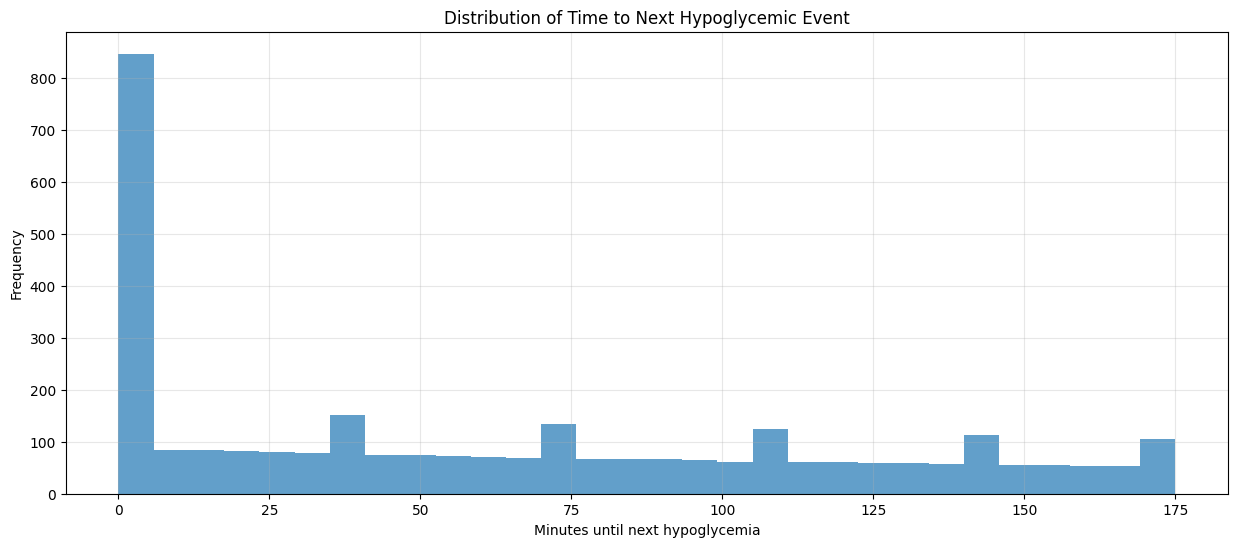

In [7]:




#--------------------------------------------------------------------------
# Section 3: Feature Engineering
#--------------------------------------------------------------------------

# Define a function to preprocess data and create features for one patient
def preprocess_patient_data(df, sequence_length=12, prediction_horizon=6):
    """
    Preprocess patient data and create features for time series prediction

    Args:
        df: Patient dataframe
        sequence_length: Number of past time steps to use (12 = 1 hour with 5-min intervals)
        prediction_horizon: How far ahead to predict (6 = 30 minutes with 5-min intervals)

    Returns:
        Processed dataframe with features
    """
    # Create a copy to avoid modifying the original
    processed_df = df.copy()

    # Sort by timestamp if available
    if 'timestamp' in processed_df.columns:
        processed_df = processed_df.sort_values('timestamp')
    else:
        processed_df = processed_df.sort_values('5minute_intervals_timestamp')

    # Handle missing values in CGM
    processed_df['cbg'] = processed_df['cbg'].interpolate(method='linear', limit=3)

    # Create target variables for glycemic events
    processed_df['hypo_event'] = (processed_df['cbg'] < 70).astype(int)
    processed_df['hyper_event'] = (processed_df['cbg'] > 180).astype(int)

    # Calculate future hypo/hyper events (within prediction horizon)
    for i in range(1, prediction_horizon + 1):
        # Hypoglycemia in the future
        processed_df[f'hypo_in_{i*5}_min'] = processed_df['hypo_event'].shift(-i)
        # Hyperglycemia in the future
        processed_df[f'hyper_in_{i*5}_min'] = processed_df['hyper_event'].shift(-i)

    # Create target variables
    # 1. Will there be a hypoglycemic event in the next 30 minutes?
    hypo_columns = [f'hypo_in_{i*5}_min' for i in range(1, prediction_horizon + 1)]
    processed_df['hypo_next_30min'] = processed_df[hypo_columns].max(axis=1)

    # 2. Will there be a hyperglycemic event in the next 30 minutes?
    hyper_columns = [f'hyper_in_{i*5}_min' for i in range(1, prediction_horizon + 1)]
    processed_df['hyper_next_30min'] = processed_df[hyper_columns].max(axis=1)

    # 3. Time to next hypoglycemic event (in minutes)
    processed_df['time_to_hypo'] = np.nan
    for i in range(len(processed_df)):
        if processed_df.iloc[i]['hypo_event'] == 1:
            # Already in hypoglycemia
            processed_df.at[processed_df.index[i], 'time_to_hypo'] = 0
        else:
            # Check future rows for hypoglycemia
            for j in range(1, 36):  # Look up to 3 hours ahead (36 * 5 min = 180 min)
                if i + j < len(processed_df) and processed_df.iloc[i + j]['hypo_event'] == 1:
                    processed_df.at[processed_df.index[i], 'time_to_hypo'] = j * 5
                    break

    # 4. Time to next hyperglycemic event (in minutes)
    processed_df['time_to_hyper'] = np.nan
    for i in range(len(processed_df)):
        if processed_df.iloc[i]['hyper_event'] == 1:
            # Already in hyperglycemia
            processed_df.at[processed_df.index[i], 'time_to_hyper'] = 0
        else:
            # Check future rows for hyperglycemia
            for j in range(1, 36):  # Look up to 3 hours ahead
                if i + j < len(processed_df) and processed_df.iloc[i + j]['hyper_event'] == 1:
                    processed_df.at[processed_df.index[i], 'time_to_hyper'] = j * 5
                    break

    # Add time-based features
    if 'timestamp' in processed_df.columns:
        processed_df['hour_of_day'] = processed_df['timestamp'].dt.hour
        processed_df['day_of_week'] = processed_df['timestamp'].dt.dayofweek

    # Calculate rolling statistics
    processed_df['glucose_rolling_mean_1h'] = processed_df['cbg'].rolling(window=12).mean()
    processed_df['glucose_rolling_std_1h'] = processed_df['cbg'].rolling(window=12).std()

    # Calculate glucose rate of change (mg/dL per 5 min)
    processed_df['glucose_change'] = processed_df['cbg'].diff()

    # Calculate acceleration (change in rate of change)
    processed_df['glucose_acceleration'] = processed_df['glucose_change'].diff()

    # Create insulin on board feature (simple approximation)
    processed_df['insulin_on_board'] = 0

    # Assuming insulin activity lasts about 4 hours (48 intervals of 5 min)
    insulin_activity = 48

    # For each bolus, calculate its effect over time
    for i in range(len(processed_df)):
        if processed_df.iloc[i]['bolus'] > 0:
            bolus_amount = processed_df.iloc[i]['bolus']

            # Add insulin effect for next 4 hours (simplified linear decay)
            for j in range(1, insulin_activity + 1):
                if i + j < len(processed_df):
                    # Linear decay of insulin effect
                    effect = bolus_amount * (1 - j/insulin_activity)
                    processed_df.at[processed_df.index[i + j], 'insulin_on_board'] += effect

    # Create carbs on board feature (simple approximation)
    processed_df['carbs_on_board'] = 0

    # Assuming carbs effect lasts about 2 hours (24 intervals of 5 min)
    carb_activity = 24

    # For each meal, calculate its effect over time
    for i in range(len(processed_df)):
        if processed_df.iloc[i]['carbInput'] > 0:
            carb_amount = processed_df.iloc[i]['carbInput']

            # Add carb effect for next 2 hours (simplified curve)
            for j in range(1, carb_activity + 1):
                if i + j < len(processed_df):
                    # Carb absorption curve (peaks at ~45-60 min then declines)
                    if j < 12:  # First hour - increasing effect
                        effect = carb_amount * (j / 12)
                    else:  # Second hour - decreasing effect
                        effect = carb_amount * (1 - (j - 12) / 12)

                    processed_df.at[processed_df.index[i + j], 'carbs_on_board'] += effect

    # Drop rows with NaN in target variables and features
    processed_df = processed_df.dropna(subset=['cbg', 'hypo_next_30min', 'hyper_next_30min'])

    return processed_df

# Process all patients' data
processed_train_data = {}
processed_test_data = {}

for patient_id, df in train_data.items():
    processed_train_data[patient_id] = preprocess_patient_data(df)
    print(f"Processed training data for patient {patient_id}: {processed_train_data[patient_id].shape}")

for patient_id, df in test_data.items():
    processed_test_data[patient_id] = preprocess_patient_data(df)
    print(f"Processed testing data for patient {patient_id}: {processed_test_data[patient_id].shape}")

# Visualize features for one patient
patient_id = list(processed_train_data.keys())[0]
patient_processed = processed_train_data[patient_id]

# Visualize time to hypo events
plt.figure(figsize=(15, 6))
valid_hypo_times = patient_processed['time_to_hypo'].dropna()
plt.hist(valid_hypo_times, bins=30, alpha=0.7)
plt.title('Distribution of Time to Next Hypoglycemic Event')
plt.xlabel('Minutes until next hypoglycemia')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig('time_to_hypo_distribution.png')
plt.show()


In [8]:

#--------------------------------------------------------------------------
# Section 4: Prepare Data for Model Training
#--------------------------------------------------------------------------

# Define function to create sequences for LSTM model
def create_sequences(df, feature_columns, target_columns, sequence_length=12):
    """
    Create sequences of data for LSTM model

    Args:
        df: Dataframe with features and targets
        feature_columns: List of feature column names
        target_columns: List of target column names
        sequence_length: Length of input sequences

    Returns:
        X: Input sequences
        y: Target values
    """
    X = []
    y = []

    # Ensure all required columns exist in the dataframe
    for col in feature_columns + target_columns:
        if col not in df.columns:
            raise ValueError(f"Column {col} not found in dataframe")

    data = df[feature_columns + target_columns].values

    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :len(feature_columns)])
        y.append(data[i + sequence_length - 1, len(feature_columns):])

    return np.array(X), np.array(y)

# Define feature columns for models
feature_columns = [
    'cbg', 'glucose_change', 'glucose_acceleration',
    'glucose_rolling_mean_1h', 'glucose_rolling_std_1h',
    'basal', 'bolus', 'carbInput', 'insulin_on_board', 'carbs_on_board',
    'hr', 'gsr'
]

# Define target columns (event prediction and time-to-event)
classification_targets = ['hypo_next_30min', 'hyper_next_30min']
regression_targets = ['time_to_hypo', 'time_to_hyper']

all_targets = classification_targets + regression_targets

# Create scaling objects for features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
regression_scaler = MinMaxScaler(feature_range=(0, 1))

# Combine all training data for fitting scalers
all_feature_data = pd.concat([df[feature_columns].dropna() for df in processed_train_data.values()])
feature_scaler.fit(all_feature_data)

# Fit regression scaler on time-to-event data (excluding NaN values)
all_regression_data = pd.concat([df[regression_targets].dropna() for df in processed_train_data.values()])
regression_scaler.fit(all_regression_data)

# Function to prepare data for one patient
def prepare_patient_data(df, sequence_length=12):
    # Make a copy to avoid modifying original
    patient_df = df.copy()

    # Fill remaining NaN values in feature columns
    for col in feature_columns:
        if col in patient_df.columns:
            patient_df[col] = patient_df[col].fillna(patient_df[col].mean())

    # Scale features
    patient_df[feature_columns] = feature_scaler.transform(patient_df[feature_columns])

    # Handle regression targets (time to events)
    # Replace NaN with a large value (indicating no event in prediction horizon)
    max_prediction_time = 180  # 3 hours

    for col in regression_targets:
        # Fill NaN with a value larger than our prediction horizon
        patient_df[col].fillna(max_prediction_time, inplace=True)

    # Scale regression targets
    patient_df[regression_targets] = regression_scaler.transform(patient_df[regression_targets])

    # Create sequences
    X, y = create_sequences(patient_df, feature_columns, all_targets, sequence_length)

    return X, y

# Prepare data for all patients
sequence_length = 12  # 1 hour of 5-minute readings

X_train = {}
y_train = {}
X_test = {}
y_test = {}

for patient_id, df in processed_train_data.items():
    X_train[patient_id], y_train[patient_id] = prepare_patient_data(df, sequence_length)
    print(f"Prepared training sequences for patient {patient_id}: {X_train[patient_id].shape}")

for patient_id, df in processed_test_data.items():
    X_test[patient_id], y_test[patient_id] = prepare_patient_data(df, sequence_length)
    print(f"Prepared testing sequences for patient {patient_id}: {X_test[patient_id].shape}")

# Combine all patients' data for general model
X_train_all = np.vstack([X_train[pid] for pid in X_train.keys()])
y_train_all = np.vstack([y_train[pid] for pid in y_train.keys()])
X_test_all = np.vstack([X_test[pid] for pid in X_test.keys()])
y_test_all = np.vstack([y_test[pid] for pid in y_test.keys()])

print(f"Combined training data shape: {X_train_all.shape}")
print(f"Combined testing data shape: {X_test_all.shape}")

ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:

#--------------------------------------------------------------------------
# Section 5: Build and Train LSTM Model
#--------------------------------------------------------------------------

# Define a multi-output LSTM model for predicting both classification and regression targets
def create_lstm_model(sequence_length, n_features, n_outputs):
    model = Sequential()

    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(64, return_sequences=True,
                                 input_shape=(sequence_length, n_features))))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))

    # Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs))

    # Compile model - use MSE for both classification and regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Create and train the model
n_features = len(feature_columns)
n_outputs = len(all_targets)

# Create the model
model = create_lstm_model(sequence_length, n_features, n_outputs)
model.summary()

# Train the model
epochs = 50
batch_size = 32

history = model.fit(
    X_train_all, y_train_all,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_glucose_model.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
)

In [ ]:

#--------------------------------------------------------------------------
# Section 6: Evaluate Model Performance
#--------------------------------------------------------------------------

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Make predictions on test data
y_pred = model.predict(X_test_all)

# Extract classification and regression predictions
y_pred_classification = y_pred[:, :len(classification_targets)]
y_pred_regression = y_pred[:, len(classification_targets):]

y_test_classification = y_test_all[:, :len(classification_targets)]
y_test_regression = y_test_all[:, len(classification_targets):]

# Convert regression predictions back to original scale
y_pred_regression_original = regression_scaler.inverse_transform(y_pred_regression)
y_test_regression_original = regression_scaler.inverse_transform(y_test_regression)

# Evaluate classification performance
# Convert continuous outputs to binary predictions using threshold of 0.5
y_pred_binary = (y_pred_classification > 0.5).astype(int)
y_test_binary = (y_test_classification > 0.5).astype(int)

# Print classification metrics
print("\nHypoglycemia Prediction Performance:")
print(classification_report(y_test_binary[:, 0], y_pred_binary[:, 0]))

print("\nHyperglycemia Prediction Performance:")
print(classification_report(y_test_binary[:, 1], y_pred_binary[:, 1]))

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_binary[:, 0], y_pred_binary[:, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Hypoglycemia Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test_binary[:, 1], y_pred_binary[:, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Hyperglycemia Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# Evaluate regression performance
# Only evaluate on rows where actual time is less than the max_prediction_time
max_prediction_time = 180
valid_hypo_mask = y_test_regression_original[:, 0] < max_prediction_time
valid_hyper_mask = y_test_regression_original[:, 1] < max_prediction_time

# Calculate regression metrics
if np.sum(valid_hypo_mask) > 0:
    mae_hypo = mean_absolute_error(
        y_test_regression_original[valid_hypo_mask, 0],
        y_pred_regression_original[valid_hypo_mask, 0]
    )
    rmse_hypo = np.sqrt(mean_squared_error(
        y_test_regression_original[valid_hypo_mask, 0],
        y_pred_regression_original[valid_hypo_mask, 0]
    ))
    print(f"\nTime-to-Hypoglycemia MAE: {mae_hypo:.2f} minutes")
    print(f"Time-to-Hypoglycemia RMSE: {rmse_hypo:.2f} minutes")
else:
    print("\nNo valid hypoglycemia events for evaluation")

if np.sum(valid_hyper_mask) > 0:
    mae_hyper = mean_absolute_error(
        y_test_regression_original[valid_hyper_mask, 1],
        y_pred_regression_original[valid_hyper_mask, 1]
    )
    rmse_hyper = np.sqrt(mean_squared_error(
        y_test_regression_original[valid_hyper_mask, 1],
        y_pred_regression_original[valid_hyper_mask, 1]
    ))
    print(f"Time-to-Hyperglycemia MAE: {mae_hyper:.2f} minutes")
    print(f"Time-to-Hyperglycemia RMSE: {rmse_hyper:.2f} minutes")
else:
    print("No valid hyperglycemia events for evaluation")

# Visualize prediction vs actual time-to-event
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(
    y_test_regression_original[valid_hypo_mask, 0],
    y_pred_regression_original[valid_hypo_mask, 0],
    alpha=0.5
)
plt.plot([0, 180], [0, 180], 'r--')
plt.title('Time to Hypoglycemia: Actual vs Predicted')
plt.xlabel('Actual Time (minutes)')
plt.ylabel('Predicted Time (minutes)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(
    y_test_regression_original[valid_hyper_mask, 1],
    y_pred_regression_original[valid_hyper_mask, 1],
    alpha=0.5
)
plt.plot([0, 180], [0, 180], 'r--')
plt.title('Time to Hyperglycemia: Actual vs Predicted')
plt.xlabel('Actual Time (minutes)')
plt.ylabel('Predicted Time (minutes)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_to_event_predictions.png')
plt.show()

In [ ]:
#--------------------------------------------------------------------------
# Section 7: Save the Model and Scalers
#--------------------------------------------------------------------------

# Save the trained model
model.save('/content/drive/MyDrive/glycemic_event_prediction_model.keras')
print("Model saved successfully!")

# Save the scalers for future use
joblib.dump(feature_scaler, '/content/drive/MyDrive/feature_scaler.pkl')
joblib.dump(regression_scaler, '/content/drive/MyDrive/regression_scaler.pkl')
print("Scalers saved successfully!")

# Save feature column names and target names for future reference
np.save('/content/drive/MyDrive/feature_columns.npy', np.array(feature_columns))
np.save('/content/drive/MyDrive/target_columns.npy', np.array(all_targets))
print("Column names saved successfully!")


In [ ]:
#--------------------------------------------------------------------------
# Section 8: Model Testing with User Input
#--------------------------------------------------------------------------

# Function to make predictions with user input
def predict_glucose_events(recent_glucose_data, recent_insulin_data, recent_meal_data,
                          recent_activity_data=None, recent_hr_data=None, recent_gsr_data=None):
    """
    Make predictions using the trained model with user input data

    Args:
        recent_glucose_data: List of recent glucose readings (at least 12 values)
        recent_insulin_data: Dictionary with 'basal' and 'bolus' lists
        recent_meal_data: List of carb intake values
        recent_activity_data: Optional - activity data
        recent_hr_data: Optional - heart rate data
        recent_gsr_data: Optional - galvanic skin response data

    Returns:
        Dictionary with predictions
    """
    # Ensure we have enough data points
    if len(recent_glucose_data) < 12:
        return {"error": "Need at least 12 glucose readings (1 hour of data)"}

    # Use the most recent 12 readings
    glucose_data = recent_glucose_data[-12:]

    # Create a dataframe with the input data
    input_df = pd.DataFrame({
        'cbg': glucose_data,
        'basal': recent_insulin_data.get('basal', [0] * len(glucose_data))[-12:],
        'bolus': recent_insulin_data.get('bolus', [0] * len(glucose_data))[-12:],
        'carbInput': recent_meal_data[-12:] if len(recent_meal_data) >= 12 else [0] * 12,
        'hr': recent_hr_data[-12:] if recent_hr_data and len(recent_hr_data) >= 12 else [70] * 12,  # Default HR
        'gsr': recent_gsr_data[-12:] if recent_gsr_data and len(recent_gsr_data) >= 12 else [1] * 12   # Default GSR
    })

    # Process the input data similar to our training pipeline
    # Calculate glucose changes
    input_df['glucose_change'] = input_df['cbg'].diff().fillna(0)
    input_df['glucose_acceleration'] = input_df['glucose_change'].diff().fillna(0)

    # Calculate rolling statistics
    input_df['glucose_rolling_mean_1h'] = input_df['cbg'].rolling(window=12, min_periods=1).mean()
    input_df['glucose_rolling_std_1h'] = input_df['cbg'].rolling(window=12, min_periods=1).std().fillna(0)

    # Calculate insulin on board and carbs on board
    # (simplified version for demo purposes)
    input_df['insulin_on_board'] = input_df['bolus'].rolling(window=12, min_periods=1).sum() * 0.5
    input_df['carbs_on_board'] = input_df['carbInput'].rolling(window=12, min_periods=1).sum() * 0.3

    # Extract features in the correct order
    input_features = input_df[feature_columns].values

    # Scale the features
    input_features_scaled = feature_scaler.transform(input_features)

    # Reshape for LSTM input [samples, time steps, features]
    input_sequence = input_features_scaled.reshape(1, 12, len(feature_columns))

    # Make prediction
    prediction = model.predict(input_sequence)[0]

    # Extract classification and regression predictions
    hypo_probability = prediction[0]
    hyper_probability = prediction[1]
    time_to_hypo_scaled = prediction[2]
    time_to_hyper_scaled = prediction[3]

    # Convert regression predictions back to original scale
    regression_predictions = regression_scaler.inverse_transform(
        np.array([[time_to_hypo_scaled, time_to_hyper_scaled]])
    )[0]

    time_to_hypo = max(0, regression_predictions[0])
    time_to_hyper = max(0, regression_predictions[1])

    # Return results
    return {
        "current_glucose": glucose_data[-1],
        "hypo_probability": float(hypo_probability),
        "hyper_probability": float(hyper_probability),
        "hypo_risk": "High" if hypo_probability > 0.7 else "Medium" if hypo_probability > 0.3 else "Low",
        "hyper_risk": "High" if hyper_probability > 0.7 else "Medium" if hyper_probability > 0.3 else "Low",
        "time_to_hypo_minutes": float(time_to_hypo) if hypo_probability > 0.3 else None,
        "time_to_hyper_minutes": float(time_to_hyper) if hyper_probability > 0.3 else None,
        "recommendation": generate_recommendation(
            glucose_data[-1], float(hypo_probability), float(hyper_probability),
            float(time_to_hypo), float(time_to_hyper)
        )
    }

# Function to generate recommendations based on predictions
def generate_recommendation(current_glucose, hypo_prob, hyper_prob, time_to_hypo, time_to_hyper):
    """Generate a recommendation based on the prediction results"""

    if current_glucose < 70:
        return "URGENT: Current glucose level is low. Consume 15-20g of fast-acting carbohydrates immediately."

    if current_glucose > 180:
        return "Your glucose is currently high. Check ketones if over 240 mg/dL. Consider taking correction insulin as advised by your healthcare provider."

    if hypo_prob > 0.7 and time_to_hypo < 30:
        return f"WARNING: High risk of hypoglycemia in approximately {int(time_to_hypo)} minutes. Consider consuming 15g of carbohydrates to prevent low blood sugar."

    if hyper_prob > 0.7 and time_to_hyper < 30:
        return f"ALERT: High risk of hyperglycemia in approximately {int(time_to_hyper)} minutes. Check for missed insulin doses or recent high-carb meals."

    if hypo_prob > 0.3:
        return f"Moderate risk of low blood sugar. Monitor closely over the next {int(time_to_hypo)} minutes."

    if hyper_prob > 0.3:
        return f"Moderate risk of high blood sugar. Be mindful of carb intake and insulin timing."

    return "Your glucose levels appear stable. Continue with regular monitoring."

# Example usage with simulated data
def test_with_sample_data():
    # Sample data from a patient in the test set
    patient_id = list(test_data.keys())[0]
    sample_df = test_data[patient_id].iloc[100:112].copy()

    # Extract required data
    recent_glucose = sample_df['cbg'].tolist()
    recent_insulin = {
        'basal': sample_df['basal'].tolist(),
        'bolus': sample_df['bolus'].tolist()
    }
    recent_meal = sample_df['carbInput'].tolist()
    recent_hr = sample_df['hr'].tolist()
    recent_gsr = sample_df['gsr'].tolist()

    # Make prediction
    prediction_result = predict_glucose_events(
        recent_glucose, recent_insulin, recent_meal,
        recent_activity_data=None, recent_hr_data=recent_hr, recent_gsr_data=recent_gsr
    )

    # Print the prediction result
    print("\nTest prediction with sample data:")
    for key, value in prediction_result.items():
        print(f"{key}: {value}")

    # Plot the recent glucose data and prediction
    plt.figure(figsize=(10, 6))

    # Plot glucose trend
    plt.plot(range(len(recent_glucose)), recent_glucose, 'b-', label='Recent glucose readings')
    plt.axhline(y=70, color='r', linestyle='--', label='Hypoglycemia threshold')
    plt.axhline(y=180, color='orange', linestyle='--', label='Hyperglycemia threshold')

    # Mark current glucose
    plt.scatter([len(recent_glucose)-1], [recent_glucose[-1]], color='blue', s=100, label='Current glucose')

    # Add prediction information
    if prediction_result['hypo_probability'] > 0.3 and prediction_result['time_to_hypo_minutes'] is not None:
        time_steps = int(prediction_result['time_to_hypo_minutes'] / 5)  # Convert minutes to 5-min intervals
        plt.scatter([len(recent_glucose)-1 + time_steps], [70], color='red', marker='X', s=150,
                    label=f"Predicted hypo in {prediction_result['time_to_hypo_minutes']:.0f} min")

    if prediction_result['hyper_probability'] > 0.3 and prediction_result['time_to_hyper_minutes'] is not None:
        time_steps = int(prediction_result['time_to_hyper_minutes'] / 5)  # Convert minutes to 5-min intervals
        plt.scatter([len(recent_glucose)-1 + time_steps], [180], color='orange', marker='X', s=150,
                    label=f"Predicted hyper in {prediction_result['time_to_hyper_minutes']:.0f} min")

    plt.title('Glucose Trend and Predictions')
    plt.xlabel('Time steps (5-minute intervals)')
    plt.ylabel('Blood Glucose (mg/dL)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

    # Display recommendation
    print("\nRECOMMENDATION:")
    print(prediction_result['recommendation'])

# Run the test function
test_with_sample_data()

In [ ]:

#--------------------------------------------------------------------------
# Section 9: Exploration of Model Limitations and Future Improvements
#--------------------------------------------------------------------------

print("\n--- Model Limitations and Future Improvements ---")
print("""
1. Data Limitations:
   - The current model is trained on data from only 6 patients
   - More diverse data is needed for a more robust model
   - Sri Lankan dietary patterns and lifestyle factors are not represented

2. Model Improvements:
   - Explore personalized models for individual patients
   - Implement more sophisticated time-to-event prediction techniques
   - Add attention mechanisms to focus on the most relevant time points

3. Feature Engineering:
   - Incorporate more advanced features related to meal composition
   - Include physical activity intensity rather than just presence/absence
   - Add time-of-day patterns and circadian rhythm features

4. Clinical Validation:
   - Need for clinical validation with diverse patient populations
   - Evaluate the real-world effectiveness of recommendations
   - Test with Sri Lankan patient data to ensure cultural relevance

5. Mobile Implementation:
   - Optimize the model for mobile deployment
   - Implement efficient data collection from various sensors
   - Design a user-friendly interface for receiving and acting on predictions
""")

# End of notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')